<h1><center>Lab1: Optical Digit Recognition</center></h1>

![Image of Yaktocat](intro.png)

## Dataset Description
* 7.291 vectors of length 256 that correspond to 16 x 16 labeled, grayscale digit pictures (train set)
* 2.007 vectors << << ...  (test set)
<br><br>

**Critical Note**:<br>
Due to the initial split of the dataset into Train and Test sets<br>
I used the "Test.txt" as the final step of the Model evaluation,<br>
and so, I used only the "Train.txt" for the Model Development 


### a) Preparatory 

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from sklearn.model_selection import learning_curve
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
from  matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import from_levels_and_colors
import seaborn as sns; sns.set()
from mlxtend.classifier import EnsembleVoteClassifier
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import BaggingClassifier

#### Step 1

In [2]:
def readDataset(path,mode):
    #read dataset
    df_columns= ['label']+list(map(lambda x : 'f'+str(x), range(1,256+1)))
    #index_col=False instead of index_col=None (default) when you have delimiters at the end of each line to turn off index column inference and discard the last column
    df= pd.read_csv(path, sep=' ', index_col=False, names=df_columns, dtype={'label': np.int32})
    
    # extract features & label
    features= df.iloc[:,1:].values
    labels= df.iloc[:,0].values
    print('X_{} shape is {}'.format(mode,features.shape))
    print('y_{} shape is {}'.format(mode,labels.shape))
    return df, features, labels

In [3]:
df_train,X_train,y_train= readDataset('data/train.txt','train')

X_train shape is (7291, 256)
y_train shape is (7291,)


In [4]:
_,X_test,y_test= readDataset('data/test.txt','test')

X_test shape is (2007, 256)
y_test shape is (2007,)


#### Step 2

In [5]:
font = {'color' : 'blue',
        'weight' : 'bold',
        'size'   : 22}

'''
Either digitLabel or title has to be set
'''
def showDigit(digitVec, digitLabel=None, title=None):
    #convert 256 length vector into 16x16 array
    digitPic= np.reshape(digitVec,(16,16))
    
    plt.imshow(digitPic, cmap='gray_r', vmin=-1, vmax=1)
    plt.axis('off') #axis are unnecessary
    c_title= title if title is not None else 'Digit {}'.format(digitLabel) #set title in condition
    plt.title(c_title, y=1.08, **font) #y increases distance between title & graph

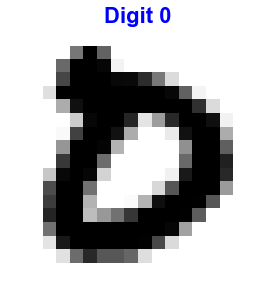

In [6]:
#get the digit at position 131 of train dataset
pos= 130
digit_vec= X_train[pos]
digit_label= y_train[pos]

#show digit
showDigit(digit_vec,digit_label)

#### Step 3

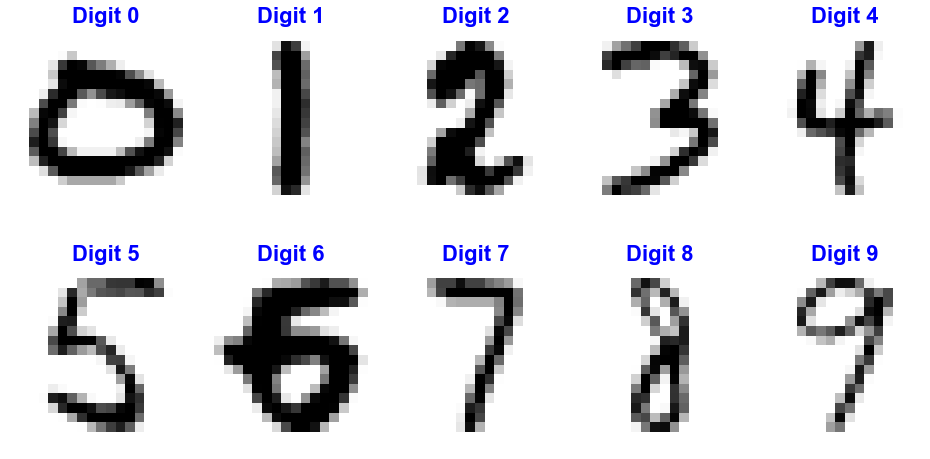

In [7]:
#from each set of samples representing a spefific digit, choose randomly one
randomSamples= [ randrange( len(y_train[ y_train == digit]) ) for digit in range(10)]

fig = plt.figure(figsize=(16,8))
for i in range(10):
    fig.add_subplot(2,5,i+1)
    showDigit( X_train[y_train==i][randomSamples[i]], i)

#### Step 4

In [8]:
#position of pixel(10,10) | considering 1-based indexing
pos= 10*16 + 10

#index = position - 1 | 0-based indexing
samples0= X_train[y_train==0]
pixelMean= samples0[:,pos-1].mean()
print('mean value of pixel(10,10) samples that correspond to digit 0 is: ',pixelMean)

mean value of pixel(10,10) samples that correspond to digit 0 is:  -0.8568450586264656


#### Step 5

In [9]:
pixelStd= samples0[:,pos-1].std()
print('std value of pixel(10,10) samples that correspond to digit 0 is: ',pixelStd)

std value of pixel(10,10) samples that correspond to digit 0 is:  0.4121841101374326


#### Step 6

In [10]:
pixels0Mean= samples0.mean(axis=0)
pixels0Std= samples0.std(axis=0)

#### Step 7

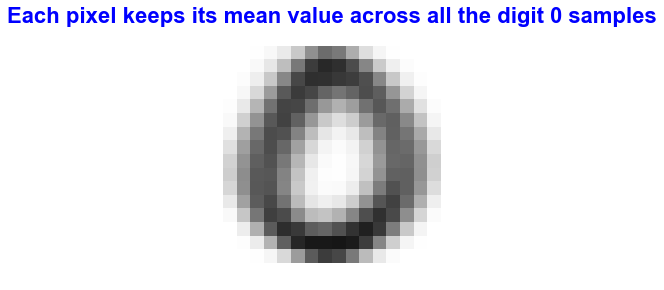

In [11]:
showDigit(pixels0Mean, title='Each pixel keeps its mean value across all the digit 0 samples')

#### Step 8

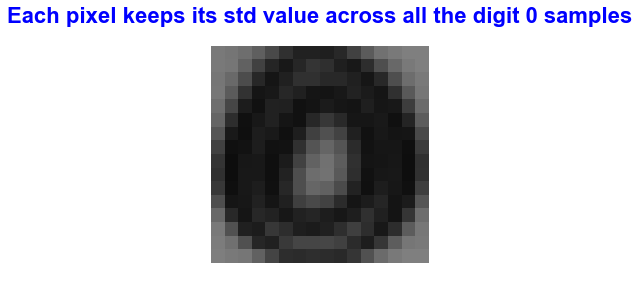

In [12]:
showDigit(pixels0Std, title='Each pixel keeps its std value across all the digit 0 samples')

**Comparison of 2 last images, say #1 and #2 respectively**
* a)
    * range of #1 is: [-1,1],
    * while that of #2 is: [0,1],
    * where -1 is white, 1 is black and 0 is grey
    * As a result, #2 hasn't white pixels

<br><br><br>    
* b)

| Mean 	|  Std 	|                       Regions                      	|                         Meaning                         	|
|:----:	|:----:	|:--------------------------------------------------:	|:-------------------------------------------------------:	|
|  low 	|  low 	|                 4 corners & center                 	|        almost white pixels | quite sure about it        	|
|  low 	| high 	|       random pixels around 4 corners & center      	| white-to-grey pixels | can be either darker or brighter 	|
| high 	|  low 	|                 see the image below                	|           almost black pixels | sure about it           	|
| high 	| high 	| thick rings with either big or small enough radius 	| grey-to-black pixels | can be either darker or brighter 	|

<br>
<img src="high_mean_low_std.jpg">

#### Step 9

#### a)

In [13]:
pixelsMean= df_train.groupby('label').mean().values
pixelsStd= df_train.groupby('label').std().values

#### b)

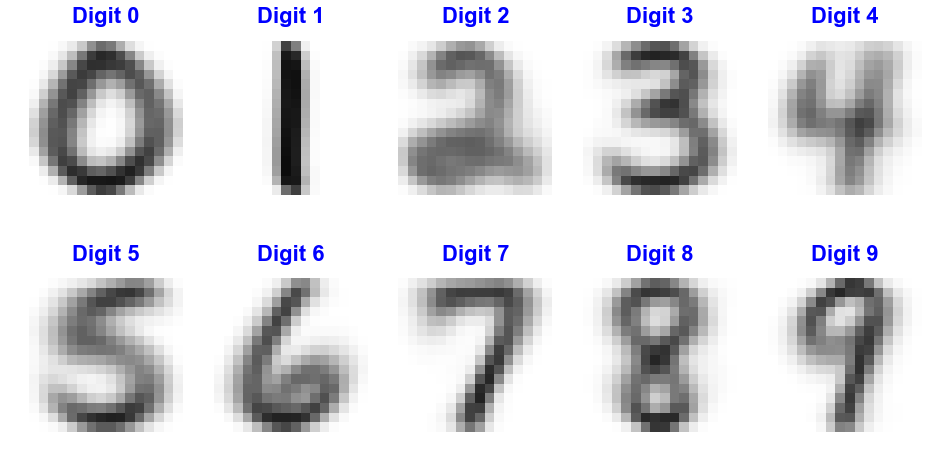

In [14]:
fig = plt.figure(figsize=(16,8))
for i in range(10):
    fig.add_subplot(2,5,i+1)
    showDigit( pixelsMean[i], i)

#### Step 10

In [15]:
sample= X_test[100]
label= y_test[100]

#calculate euclidean distance (L2 norm) between the sample and all the centers
distance= np.linalg.norm(sample-pixelsMean, axis=1)

#predict the class that corresponds to the smallest value
prediction= np.argmin(distance)

print('We predicted that the 101st sample represents digit {}.\nThat is {}!'.format(prediction, prediction == label))

We predicted that the 101st sample represents digit 0.
That is True!


#### Step 11

In [16]:
#calculate euclidean distance (L2 norm) between each test sample and all the centers
distances= np.array( [np.linalg.norm(testSample-pixelsMean, axis=1) for testSample in X_test] )

#predict for each sample the class that corresponds to the smallest value
predictions= np.argmin(distances, axis=1)

hits, total= np.sum(predictions == y_test), len(y_test)
print('We predicted correclty {} out of {} test samples -> accuracy: {:2.2f}%'.format(hits, total, hits*100/total))

We predicted correclty 1634 out of 2007 test samples -> accuracy: 81.42%


#### Step 12

In [17]:
class MyEuclideanClassifier(BaseEstimator):

    class NotFittedError:
        pass 
    
    
    def checkType(self, *argv):
        for arg in argv:
            if type(arg) not in [list, np.ndarray]:
                print(type(arg),arg)
                raise TypeError('Input\'s type must be either python list or numpy array')
    
    def toNpArray(self, this_list):
        if type(this_list) == list:
            return np.array(this_list)
        return this_list
    
    def check_inputs_dim(self,X,Y,axis=0):
        if X.shape[axis] != Y.shape[axis]:
            raise ValueError('Invalid input dimension')    
            
    def __init__(self):
        self.means= None
        self.preds_= None
    
    
    def fit(self, X_train, y_train):
        self.checkType(X_train,y_train)
        
        #X_train, y_train = self.toNpArray(X_train), self.toNpArray(y_train)
        X_train= self.toNpArray(X_train)
        y_train= self.toNpArray(y_train)
        try:
            self.check_inputs_dim(X_train,y_train)
        except ValueError:
            raise ValueError('#samples not equals #labels in train set')

        self.X_train= X_train
        self.y_train= y_train
        
        self.classes= np.unique(y_train)
        self.means= self.toNpArray( [ X_train[y_train==thisClass].mean(axis=0) for thisClass in self.classes ] )
        
        # Return the classifier
        return self
        
    
    def predict(self, X_test):
        if self.means is None:
            raise NotFitterError("This classifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.")
        
        X_test = self.toNpArray(X_test)
        try:
            self.check_inputs_dim(self.X_train,X_test,axis=1)
        except ValueError:
            raise ValueError('#features in train and test set is inconsistent')
        
        
           
        #calculate euclidean distance (L2 norm) between each test sample and all the centers
        distances= np.array( [np.linalg.norm(testSample-self.means, axis=1) for testSample in X_test] )

        #predict for each sample the class that corresponds to the smallest value
        self.preds_= np.argmin(distances, axis=1)
        return self.preds_
        
    def score(self, X_test, y_test):
        #Even if self.predict != None, they may belong to different X_test data 
        self.predict(X_test)
        
        X_test, y_test = self.toNpArray(X_test), self.toNpArray(y_test)
        try:
            self.check_inputs_dim(X_test,y_test)
        except ValueError:
            raise ValueError('#samples not equals #labels in test set')
        
        return np.sum(self.preds_ == y_test) / y_test.shape[0]

In [18]:
clf= MyEuclideanClassifier()
_= clf.fit(X_train,y_train)
score= clf.score(X_test,y_test)
print('My Euclidean Classifier accuracy: {:2.2f}%'.format(score*100))

Euclidean Classifier accuracy: 81.42%


#### Step 13

#### a)

In [19]:
#In real world applications we do not have access to test data
#so, only train set is being consider to evaluate the performance of the classifier
resutls= cross_validate(clf, X_train, y=y_train, cv=5, return_train_score=True, scoring=['accuracy'])
print('Some info about the 5-fold cross-validation process:')
resutls

Some info about the 5-fold cross-validation process:


{'fit_time': array([0.1075387 , 0.08505177, 0.05963731, 0.06354737, 0.0635457 ]),
 'score_time': array([0.03910398, 0.02835083, 0.03128171, 0.03323555, 0.03814316]),
 'test_accuracy': array([0.84921179, 0.85116598, 0.84567901, 0.84910837, 0.84773663]),
 'train_accuracy': array([0.85048011, 0.84930567, 0.85444883, 0.85290588, 0.85136294])}

In [48]:
print('As your model evatuation, we keep the average of the test_accuracy across all the splits\n')
print('Euclidean Classifier accuracy through 5-fold cross-validation: {:2.2f}%'.format(resutls['test_accuracy'].mean()*100))

As your model evatuation, we keep the average of the test_accuracy across all the splits

Euclidean Classifier accuracy through 5-fold cross-validation: 84.86%


#### b)

In order to visualize the classification region of Euclidean Classifier in 2-D (an image),<br>
we should reduce the 256 dimensions to 2 dimensions.<br>
So, we apply PCA.

In [21]:
#we will use pca with 2 principal components
pca= PCA(n_components=2)

#1. fit the model with X_train and 2. transform X_tran
X_train_PCA= pca.fit_transform(X_train)

In [22]:
clf_PCA= MyEuclideanClassifier()
_= clf_PCA.fit(X_train_PCA,y_train)

In [24]:
def plot_clf(clf, X, y, mode='surface'):
    fig, ax = plt.subplots()
    # title for the plots
    if mode== 'noSurface':
        title= ('Samples in 2D')
    elif mode == 'onlySurface':
        title= 'Decision Surface & samples'
    else:
        title = ('Decision surface & Classifier')
    
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    
    x_min, x_max = X0.min() - 1, X0.max() + 1
    y_min, y_max = X1.min() - 1, X1.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .05),
                         np.arange(y_min, y_max, .05))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    cmap = cm.get_cmap("rainbow",10)
    custom_lines =[ Line2D([0], [0], color=cmap(i), lw=7) for i in range(11)]
    
    if mode in ['surface','onlySurface']:
        out = ax.contourf(xx, yy, Z+0.5, alpha=0.8, cmap=cmap, levels = np.append(np.unique(y),max(y)+1))
        
    if mode in ['surface','noSurface']:
        ax.scatter(X0, X1, c=y, s=60, alpha=0.8, cmap=cmap,edgecolors='k')
        
    if mode == 'onlySurface':
        for cmean,cclass in zip(clf.means,clf.classes):
            plt.text(cmean[0],cmean[1], str(cclass), fontsize=12)
        plt.text(np.min(xx), np.min(yy)-1, '*numbers are placed at means\' position', fontsize=12)
    
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.legend(custom_lines, list(range(10)))
    plt.show()

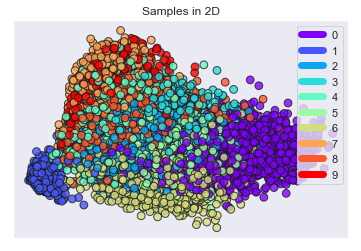

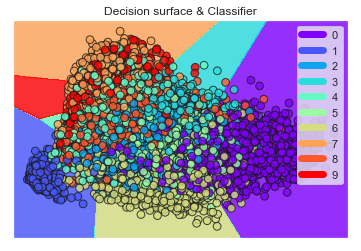

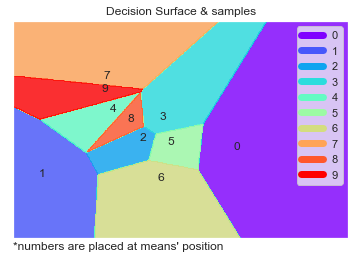

In [25]:
labels= ['digit'+str(digit) for digit in range(10)]

plot_clf(clf_PCA, X_train_PCA, y_train, 'noSurface')
plot_clf(clf_PCA, X_train_PCA, y_train)
plot_clf(clf_PCA, X_train_PCA, y_train, 'onlySurface')

In [26]:
#test the score of the new classifier

#tranform X_test
X_test_PCA= pca.transform(X_test)

successRatePCA= clf_PCA.score(X_test_PCA,y_test)
print('Euclidean Classifier accuracy with dimensionality reduction: {:2.2f}%'.format(successRatePCA*100))
print('This follows our intuition due to the loss of information')

Euclidean Classifier accuracy with dimensionality reduction: 51.62%
This follows our intuition due to the loss of information


#### c)

In [27]:
def plot_learning_curve(train_scores, test_scores, train_sizes, ylim=(0, 1)):
    plt.figure()
    plt.title("Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

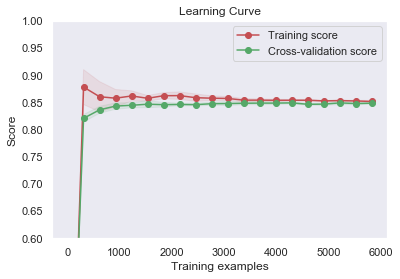

In [28]:
train_sizes, train_scores, test_scores = learning_curve(MyEuclideanClassifier(), X_train, y_train, cv=5, train_sizes=np.linspace(.001, 1.0, 20))

plot_learning_curve(train_scores, test_scores, train_sizes, ylim=(.6, 1))

The above two diagrams show how well the classifier works, when considering gradually increasing examples size onn which we both train and evaluate our classifier
If we consider only 1 example, it\s a trivial process
While, as we consider larger number of examples, we can a resultin error
Note that Training Score is more confident than Cross-Validation Score and they meet as #examples grows


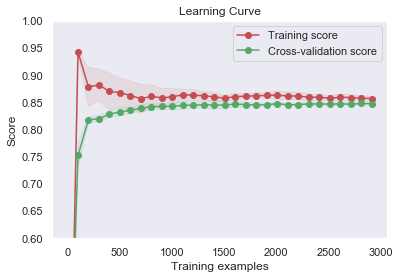

In [29]:
train_sizes, train_scores, test_scores = learning_curve(MyEuclideanClassifier(), X_train, y_train, cv=5, train_sizes=np.linspace(0.0001, 0.5, 30))

plot_learning_curve(train_scores, test_scores, train_sizes, ylim=(.6, 1))
print('The above two diagrams show how well the classifier works, when considering gradually increasing examples size onn which we both train and evaluate our classifier')
print('If we consider only 1 example, it\s a trivial process')
print('While, as we consider larger number of examples, we can a resultin error')
print('Note that Training Score is more confident than Cross-Validation Score and they meet as #examples grows')

### b) Lab Main Steps  

#### Step 14

In [30]:
#find the unique classes along with their counts
classes,counts = np.unique(y_train, return_counts=True)
aprioris= counts / counts.sum() 

print('Class \t Apriori Prob\tDistance from perfectly balanced dataset')
for cl,pr,d in zip(classes,aprioris, aprioris*aprioris.shape[0]-1):
    print('  {}\t    {:2.2f}\t\t\t{}{:2.1f}%'.format(cl,pr*100, '+' if np.sign(d) == 1 else '-',abs(d)*100))

Class 	 Apriori Prob	Distance from perfectly balanced dataset
  0	    16.38			+63.8%
  1	    13.78			+37.8%
  2	    10.03			+0.3%
  3	    9.02			-9.8%
  4	    8.94			-10.6%
  5	    7.63			-23.7%
  6	    9.11			-8.9%
  7	    8.85			-11.5%
  8	    7.43			-25.7%
  9	    8.83			-11.7%


#### Step 15

#### a)

<h3><center>Bayes</center></h3>

$\text{Let's say we have:}$
* $\text{C classes } ω_1, \dots, ω_C $
<br>$\text{and}$
* $\text{d features: }\mathbf{x} = [ x_1, \dots, x_d ]^T $

<br>$ \text{So, Bayes Classifier, given a sample } \mathbf{x},$
<br>$\text{predicts the class that correspond to }$
<br>$$\hat{ω} =
\underset{i\in\{1,\dots,C\}}{\operatorname{argmax}}P(ω_i \mid x_1, \dots, x_d)$$
<br>$\text{So, let's examine}$
$$P(ω_i \mid x_1, \dots, x_d)$$
<br>
$$  = \frac{P(x_1, \dots, x_d \mid ω_i) * P(ω_i)}{P(x_1, \dots, x_d)} $$
<br>
$$  = \frac{P(x_1 \mid x_2, \dots, x_d, ω_i) * P(x_2 \mid x_3, \dots, x_d, ω_i) * \dots * P(x_n-1 \mid x_d, ω_i) * P(x_d \mid ω_i) * P(ω_i)}{P(x_1, \dots, x_d)} $$

<br><br>
<h3><center>Naive Bayes</center></h3>
<br>
$ \text{Naive Bayes comes with the assumption that the features } x_i \text{ are iid (Independent and Identically Distributed) random variables}$
<br><br>$ \text{ independent }$
$$  = \frac{P(x_1 \mid ω_i) * P(x_2 \mid ω_i) * \dots * P(x_n-1 \mid ω_i) * P(x_d \mid ω_i) * P(ω_i)}{P(x_1, \dots, x_d)} $$
<br>$$ = \frac{P(ω_i)*\prod_{j=1}^{d} P(x_j \mid ω_i)}{P(x_1, \dots, x_d)}$$
<br>$\text{We can ignore the denominator since it is constant across all the aposterior calculations.}$
<br>$\text{So,}$
<br>$$ \hat{ω} = \underset{i\in\{1,\dots,C\}}{\operatorname{argmax}} P(ω_i)*\prod_{j=1}^{d} P(x_j \mid ω_i)$$
<br>$\text{Suppose that, given a class }ω_i \text{, the feature } x_j \sim \mathcal{N}(\mu_{ω_i},\,\sigma_{ω_{i,j}}^{2})\,$
<br>$$P(x_j \mid ω_i) = \frac{1}{\sqrt{2\pi\sigma^2_{ω_{i,j}}}} \exp\left(-\frac{(x_j - \mu_{ω_{i,j}})^2}{2\sigma^2_{ω_{i,j}}}\right)$$
<br>$\text{We result in}$
<br>$$ \hat{ω} = \underset{i\in\{1,\dots,C\}}{\operatorname{argmax}}P(ω_i)*\prod_{j=1}^{d} \frac{1}{\sqrt{2\pi\sigma^2_{ω_{i,j}}}} * \exp\left(-\frac{(x_j - \mu_{ω_{i,j}})^2}{2\sigma^2_{ω_{i,j}}}\right)$$

In [31]:
class MyNaiveBayesClassifier(BaseEstimator):  
    
    class NotFittedError:
        pass 
    
    
    def checkType(self, *argv):
        for arg in argv:
            if type(arg) not in [list, np.ndarray]:
                print(type(arg),arg)
                raise TypeError('Input\'s type must be either python list or numpy array')
    
    def toNpArray(self, this_list):
        if type(this_list) == list:
            return np.array(this_list)
        return this_list
    
    def check_inputs_dim(self,X,Y,axis=0):
        if X.shape[axis] != Y.shape[axis]:
            raise ValueError('Invalid input dimension')
    
    def ckeck_aprioris_dim(self,y,axis=0):
        if self.aprioris_ is not None  and  np.unique(y_train).shape[axis] != self.aprioris_.shape[axis]:
                raise ValueError('Invalid input dimension')            
        
    def predict_sample(self,sample):
        pdfs_Nom= np.exp( -((sample - self.means_) ** 2) / (2*self.stds_**2) )
        pdfs_Den= self.stds_ * math.sqrt(2*math.pi)
        
        #find the index of the class with the maximum aposteriori, map that index into the real class
        return self.classes_[ np.argmax( np.prod( pdfs_Nom/pdfs_Den, axis=1) * self.aprioris_ ) ]

    
    def __init__(self, std=False, priors= None):
        self.std_= std
        self.aprioris_= priors
        self.classes_= None
        self.preds_= None 
        self.means_= None
        self.stds_= None
        
    
    def fit(self, X_train, y_train):
        self.checkType(X_train,y_train)
        
        #X_train, y_train = self.toNpArray(X_train), self.toNpArray(y_train)
        X_train= self.toNpArray(X_train)
        y_train= self.toNpArray(y_train)
        try:
            self.check_inputs_dim(X_train,y_train)
            self.ckeck_aprioris_dim(y_train)
        except ValueError:
            raise ValueError('#samples not equals #labels in train set or aprioris length is wrong')

        self.X_train= X_train
        self.y_train= y_train
        
        self.classes_= np.unique(y_train)
        
        #calc the apriori probs if they not have been passed from the user
        #if self.aprioris_ is not None:
        if self.aprioris_ is None:
             self.aprioris_= np.array( [sum(y_train == thisClass) / len(y_train) for thisClass in self.classes_])

        #calculate the mean, std for each feature for all classes
        self.means_= np.array([ X_train[y_train == digit].mean(axis=0) for digit in self.classes_])
        
        if not self.std_:
            self.stds_= np.array([ X_train[y_train == digit].std(axis=0) for digit in self.classes_])
            #prevent zero std values that causes NA pdf values
            minStd_value= self.stds_[self.stds_ > 0].min().min()
            self.stds_+= minStd_value/10
        else:
            self.stds_= self.std_*np.ones(self.means_.shape)
        return self

    def predict(self, X_test):
        if self.means_ is None or self.stds_ is None:
            raise NotFitterError("This classifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.")
        
        X_test = self.toNpArray(X_test)
        try:
            self.check_inputs_dim(self.X_train,X_test,axis=1)
        except ValueError:
            raise ValueError('#features in train and test set is inconsistent')

        self.preds_= np.array([ self.predict_sample(sample) for sample in X_test])
        return self.preds_
    
    
    def score(self, X_test, y_test):
        #Even if self.predict != None, they may belong to different X_test data 
        self.predict(X_test)
        
        X_test, y_test = self.toNpArray(X_test), self.toNpArray(y_test)
        try:
            self.check_inputs_dim(X_test,y_test)
        except ValueError:
            raise ValueError('#samples not equals #labels in test set')
        
        return np.sum(self.preds_ == y_test) / y_test.shape[0]

#### b)

In [78]:
my_nbc= MyNaiveBayesClassifier(priors= aprioris)
my_nbc.fit(X_train, y_train)
print('Accuracy: {:.2f} [My Naive Bayes]'.format(my_nbc.score(X_test,y_test)))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Accuracy: 0.71 [My Naive Bayes score]


#### c)

In [79]:
gnb = GaussianNB(priors= aprioris)
gnb.fit(X_train, y_train)
print('Accuracy: {:.2f} [Sklearn Naive Bayes]'.format(gnb.score(X_test,y_test)))

Accuracy: 0.72 [Sklearn Naive Bayes]


#### Step 16

Let's see what changes to the above type, when assuming std = 1

<br>$$ \hat{ω} = \underset{i\in\{1,\dots,C\}}{\operatorname{argmax}}P(ω_i)*\prod_{j=1}^{d} \frac{1}{\sqrt{2\pi\sigma^2_{ω_{i,j}}}} * \exp\left(-\frac{(x_j - \mu_{ω_{i,j}})^2}{2\sigma^2_{ω_{i,j}}}\right)$$
<br>$$ = \underset{i\in\{1,\dots,C\}}{\operatorname{argmax}}P(ω_i)* (\frac{1}{2\pi})^{d/2} * \prod_{j=1}^{d} \exp\left(-\frac{(x_j - \mu_{ω_{i,j}})^2}{2}\right)$$
<br>$$ = \underset{i\in\{1,\dots,C\}}{\operatorname{argmax}}P(ω_i) * \exp \left( \sum_{j=1}^{d} -\frac{(x_j - \mu_{ω_{i,j}})^2}{2}\right)$$
<br>$$ = \underset{i\in\{1,\dots,C\}}{\operatorname{argmax}}P(ω_i)  * \exp\left(-\frac{1}{2}*\lVert\textbf{x}-\boldsymbol{\mu_{ω_i}}\rVert^2\right)$$
<br>$$ = \underset{i\in\{1,\dots,C\}}{\operatorname{argmax}} \ln \left(P(ω_i)\right) -\frac{1}{2} \lVert\textbf{x}-\boldsymbol{\mu_{ω_i}}\rVert^2$$
So, we result in
<br>$$\hat{ω} = \underset{i\in\{1,\dots,C\}}{\operatorname{argmin}} \frac{1}{2} \lVert\textbf{x}-\boldsymbol{\mu_{ω_i}}\rVert^2 - \ln \left(P(ω_i)\right)$$
<br>Which is close to Euclidean Classifier but also takes into account the priors.
<br>Euclidean Classifier is the case where all priors are equal.

In [77]:
gnb_std1 = MyNaiveBayesClassifier(priors= aprioris, std=1)
gnb_std1.fit(X_train, y_train)
print('Accuracy: {:.2f} [My Naive Bayes /w unit std]'.format(gnb_std1.score(X_test,y_test)))

Accuracy: 0.81 [My Naive Bayes /w unit std]


# SOS results explanation per class - comparison with step 15

In [35]:
def plot_confusion_matrix(y_true, y_pred, fig, ax, allClasses, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = allClasses[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #print(cm)

    #fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Comparison of Confusion matrices of Gaussian Naive Bayes Models


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


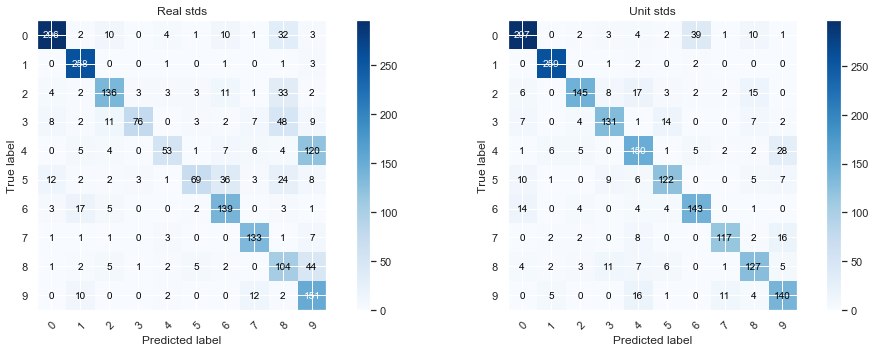

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

print('Comparison of Confusion matrices of Gaussian Naive Bayes Models')

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, my_nbc.predict(X_test), fig, ax1, allClasses=np.arange(10), title='Real stds');
#plt.subplot(1,2,ax1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, gnb_std1.predict(X_test), fig, ax2, allClasses=np.arange(10), title='Unit stds');
#plt.subplot(1,2,ax2)


In [37]:
classStds= np.array([ X_train[y_train == digit].std(axis=0) for digit in classes])

res= []
for c,f1_reg,f1_unt in zip(classes,f1_score(y_test, my_nbc.predict(X_test), average=None) , f1_score(y_test, gnb_std1.predict(X_test), average=None)):
    #print('  {}\t        {:1.2f}\t\t        {:1.2f}'.format(c,f1_reg,(f1_unt)))
    res.append([f1_reg,f1_unt])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


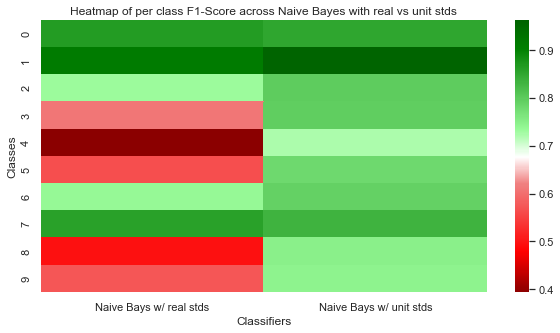

In [38]:
c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

data= res
plt.figure(figsize=(10,5))
ax = sns.heatmap(data, cmap=cmap)
ax.set_xlabel("Classifiers")
ax.set_xticklabels(['Naive Bays w/ real stds','Naive Bays w/ unit stds'])
ax.set_ylabel("Classes")
ax.set_title("Heatmap of per class F1-Score across Naive Bayes with real vs unit stds");

#### Step 17

a) **k-Nearest Neighbors Classification Algorithm** (**k-NN**) :  each new sample is classified by the majority vote of its  k neighbors
        <br>small k ~> high bias
        <br>big k ~> high variance
        
    *Note1: In Binary Classification k must be odd to prevent ties 
            (e.g. let k be 2 and nearest neighbor belongs in class 1 while the 2nd nearest belongs in class 2)
    
    *Note2: In Multiclass Classification ties can occur with k either odd or even 
            (e.g. k=3, #classes=3: 1st nearest neighbor belongs in class 1, 2nd << in class 2, 3rd << in class 3)
            But again, setting odd k makes less possible the case of tie

<br>

b) **Support Vector Machines for Classification** (**SVMs**)
   
   For simplicity purposes **x** e $\mathbb{R^2}$, #classes=2, the 2 classes are linear separable and we try to find the widest possible separation between the 2 classes.
   
   So, in order to maximize the width, we get some **constraints** regarding the projection of the vectors, laying in the gather, to the vector that is perpenticular to the pair of lines that form the width. 
   
   This problem can be solved using **Lagrange Multipliers**. But if we observe how this maximization **depends on our samples**, it is clear that it depends on their **dot product**. 
   
   When classes are not linear seperable we can **implicitly** go to higher dimensions using a tranformation φ(**x**). 
   
   So, the new calculations depend on the dot product of the transformations. Although, we would need O($\mathbb{2^m}$) in order to get to $\mathbb{R^m}$, there are some cases we can calculate this              product without expanding these transformations. 
   
   <br>**e.g.**  φ(x)= [1 $\mathbb{x_1^2}$  $\mathbb{2^.5}$$\mathbb{x_1x_2}$  $\mathbb{x_2^2}$  $\mathbb{2^.5}$$\mathbb{x_1}$  $\mathbb{2^.5}$$\mathbb{x_2}$],  $\,\,\,->\,\,\,\,φ(\mathbb{x_i}$)*φ($\mathbb{x_j})\,\,\,\,$ = $\,\,\,\,$ [1 + φ( $\mathbb{x_i}$)*φ($\mathbb{x_j}$) ]^2  which means Θ($\mathbb{m}$) calculations instead of Θ($\mathbb{m^2}$)
   
   To conclude, there are some products $φ(\mathbb{x_i}$)*φ($\mathbb{x_j})$ with this behavior, called **Kernels**
   
   **Linear Kernel**: K($\mathbb{x_i}$,$\mathbb{x_j}$) = $\mathbb{x_i}$ * $\mathbb{x_j}$<br>
   
   **p Polynomial Kernel**: K($\mathbb{x_i}$,$\mathbb{x_j}$) =  [1 + φ( $\mathbb{x_i}$)*φ($\mathbb{x_j}$) ]^p<br>
   
   **RBF Kernel**: K($\mathbb{x_i}$,$\mathbb{x_j}$) = $\exp(-\lVert\textbf{x}-\boldsymbol{\mu_ω}\rVert^2) /2*\sigma^2 $

In [75]:
clfs = [
        [MyEuclideanClassifier(),'Euclidean Classifier'],
        [MyNaiveBayesClassifier(), 'Gaussian Naive Bayes Classifier'],
        [KNeighborsClassifier(n_neighbors=3), 'k-Nearest Neighbors Classifier'],
        [svm.SVC(kernel='linear',gamma='scale'), 'SVM w/ linear kernel'],
        [svm.SVC(kernel='poly',gamma='scale'), 'SVM w/ polynomial kernel'],
        [svm.SVC(kernel='rbf',gamma='scale'), 'SVM w/ rbf kernel']
       ]

results= []
for clf, label in clfs:
    scores= cross_validate(clf, X_train, y_train, cv=5, scoring='f1_weighted')['test_score']
    results.append([scores.mean(),scores.std(),label])

print('5-fold Cross Validation\n') 
for scores_mean, scores_td,label in sorted(results, key=lambda row: row[0], reverse=True):
    print("F1_weighted: {:0.2f} (+/- {:0.3f}) [{}] ".format(scores_mean, scores_td,label))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


5-fold Cross Validation

F1_weighted: 0.98 (+/- 0.002) [SVM w/ polynomial kernel] 
F1_weighted: 0.98 (+/- 0.002) [SVM w/ rbf kernel] 
F1_weighted: 0.96 (+/- 0.006) [k-Nearest Neighbors Classifier] 
F1_weighted: 0.95 (+/- 0.005) [SVM w/ linear kernel] 
F1_weighted: 0.85 (+/- 0.003) [Euclidean Classifier] 
F1_weighted: 0.72 (+/- 0.031) [Gaussian Naive Bayes Classifier] 


So, I will optimize and tune the parameters of the first model from the above list.
<br>Then I will test it on the test set.

In [150]:
grid = GridSearchCV(svm.SVC(kernel='poly',gamma='scale'),
                    param_grid={"degree": [3,5,7,9],
                                "tol": [1e-5, 1e-3, 1e-5],
                                "gamma": ['scale',0.1, 1, 10]},
                                scoring="f1_weighted",
                    cv=5, n_jobs=-1)

grid.fit(X_train, y_train)

print("Biased Best score = {:.3f}, Best parameters = {}".format(grid.best_score_, 
                                                     grid.best_params_))

best_params = grid.best_params_

Biased Best score = 0.980, Best parameters = {'degree': 3, 'gamma': 0.1, 'tol': 1e-05}


Cross-validation after parameter tuning is occuring because the best score of GridSearch is guided by the whole processand
<br>might be a biased, optimistic, estimate of the true performance of the model.

In [153]:
clf= svm.SVC(kernel='poly', degree= 3, gamma= 0.1, tol= 1e-05 )
scores = cross_validate(clf, X_train, y=y_train, cv=6, scoring=['f1_weighted'])['test_f1_weighted']

# Unbiased estimate of the accuracy
print("Unbiased Best score = {:.3f} +- {:.3f}".format(np.mean(scores), np.std(scores)))

Unbiased Best score = 0.981% +- 0.002


evaluate on test data

In [151]:
print("Test Score: {:0.3f}  [F1-weighted] ".format( f1_score(y_test, clf.fit(X_train,y_train).predict(X_test), average='weighted') ))

Test Score: 0.953  [F1-weighted] 


### Step 18

Compare the per class score of each classifier
* Sort the classifier by F1-Weighed Score
* Calculate per class F1-Score

In [42]:
clfs = [
        [svm.SVC(kernel='poly',gamma='scale'), 'SVM w/ polynomial kernel'],
        [svm.SVC(kernel='rbf',gamma='scale'), 'SVM w/ rbf kernel'],
        [KNeighborsClassifier(n_neighbors=3), 'k-Nearest Neighbors Classifier'],
        [svm.SVC(kernel='linear',gamma='scale'), 'SVM w/ linear kernel'],
       ]

f1_res= []
labels= []
for clf, label in clfs:
    #f1_res.append([label, f1_score(y_test, clf.fit(X_train,y_train).predict(X_test), average=None)])
    f1_res.append(f1_score(y_test, clf.fit(X_train,y_train).predict(X_test), average=None))
    labels.append(label)

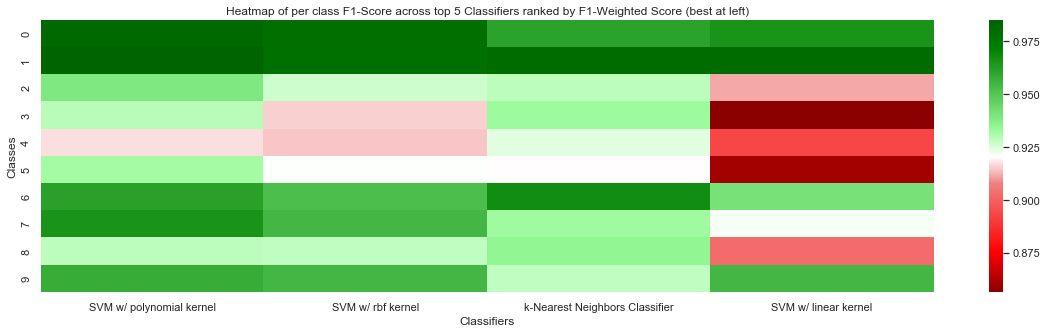

In [43]:
c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

data= f1_res
plt.figure(figsize=(20,5))
ax = sns.heatmap(np.transpose(data), cmap=cmap)
ax.set_xlabel("Classifiers")
ax.set_xticklabels(labels)
ax.set_ylabel("Classes")
ax.set_title("Heatmap of per class F1-Score across top 5 Classifiers ranked by F1-Weighted Score (best at left)");
plt.show()

#### a)

### Voting Classifier

#### hard voting
simply the (weighted) plurality  voting

Using odd number of classifiers is a must practice in binary and a good practice in multi-class classification.
<br>It is true that in the second case such a practice would just decrease the chances of a tie.
<br>Although, one could use an even number of classifiers, say 2, if the ties were being handled.

In [121]:
clf1=[svm.SVC(kernel='poly',gamma='scale'), KNeighborsClassifier(n_neighbors=3)]
eclf1 = EnsembleVoteClassifier(clfs= clf1, voting= 'hard',weights=[0.51,0.49]) #svm poly wins in tie

clf2=[svm.SVC(kernel='poly',gamma='scale'), KNeighborsClassifier(n_neighbors=3),svm.SVC(kernel='rbf',gamma='scale')]
eclf2 = EnsembleVoteClassifier(clfs= clf2, voting= 'hard', weights=[0.34,0.33,0.33]) #svm poly wins in tie

clfs= [eclf1, eclf2]
labels = ['Ensemble of SVM poly & k-NN', 'Ensemble of SVMs poly & rbf & k-NN']

print('Hard Voting | 5-fold Cross Validation\n')
for clf,label in zip(clfs,labels):
    scores = cross_validate(clf, X_train, y=y_train, cv=5, scoring=['f1_weighted'])['test_f1_weighted']
    print("F1_weighted: {:0.2f} (+/- {:0.2f}) [{}]".format(scores.mean(), scores.std(),label))

Hard Voting | 5-fold Cross Validation

F1_weighted: 0.98 (+/- 0.00) [Ensemble of SVM poly & k-NN]
F1_weighted: 0.98 (+/- 0.00) [Ensemble of SVMs poly & rbf & k-NN]


#### soft voting
the weighted sum of class probs

in soft voting only classifiers that calculate probs can be used such as Bayes, SVMs 

In [122]:
clf=[svm.SVC(kernel='poly',gamma='scale'),svm.SVC(kernel='rbf',gamma='scale'),GaussianNB()]
eclf = EnsembleVoteClassifier(clfs= clf2, voting= 'hard')

label = ['Ensemble of SVMs poly & rbf & Naive Bayes']

print('Soft Voting | 5-fold Cross Validation\n')
scores = cross_validate(eclf, X_train, y=y_train, cv=5, scoring=['f1_weighted'])['test_f1_weighted']
print("F1_weighted: {:0.2f} (+/- {:0.2f}) {}".format(scores.mean(), scores.std(),label))

Soft Voting | 5-fold Cross Validation

F1_weighted: 0.98 (+/- 0.00) [['Ensemble of SVMs poly & rbf & Naive Bayes']]


#### b)

### BaggingClassifier
split train set into several, overlapping batches and train classifier on each of them 

In [132]:
#clfs=[('svm-poly',svm.SVC(kernel='poly',gamma='scale')), ('k-NN',KNeighborsClassifier(n_neighbors=3))]

print('Bagging\n')

bg = BaggingClassifier(base_estimator= svm.SVC(kernel='poly',gamma='scale'), n_estimators= 10, max_samples= 0.6)
print("F1_weighted: {:0.2f} [{}]".format(f1_score(y_train, bg.fit(X_train,y_train).predict(X_train), average='weighted'), 'Ensemble of SVMs poly'))

Bagging

F1_weighted: 0.99 [Ensemble of SVMs poly]


In [128]:
print("F1_weighted: {:0.2f} (+/- {:0.2f}) [{}]".format(scores.mean(), scores.std(),label))

F1_weighted: 0.98 (+/- 0.00) [['Ensemble of SVMs poly & rbf & Naive Bayes']]


### Step 19

#### a)

In [38]:
class DigitDataset(Dataset):
    
    def __init__(self, file):
        
        df_columns= ['label']+list(map(lambda x : 'f'+str(x), range(1,256+1)))
        #index_col=False instead of index_col=None (default) when you have delimiters at the end of each line to turn off index column inference and discard the last column
        df_values= pd.read_csv(file, sep=' ', index_col=False, names=df_columns, dtype={'label': np.int32}).values
        
        self.x_data= torch.from_numpy(df_values[:,1:]).float()
        #self.y_data= torch.from_numpy(df_values[:,0].astype(int))
        #1-hot
        labels= df_values[:,0]
        uniq_classes= np.unique(labels).shape[0]
        one_hot=torch.zeros(df_values.shape[0], uniq_classes)
        one_hot[np.arange(df_values.shape[0]), labels] = 1
        self.y_data= one_hot
        
        self.len= df_values.shape[0]
        
    def __len__(self):
          return self.len
        
    def __getitem__(self,idx):
        return self.x_data[idx], self.y_data[idx]

In [40]:
train_set= DigitDataset('data/train.txt')
batch_size= 32

#the whole train set here
train_loader= DataLoader(dataset=train_set, shuffle=True, batch_size=batch_size)

#### b+c)

In [78]:
class MLNet(torch.nn.Module):
    
    def __init__(self, layersList):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(MLNet, self).__init__()
        
        layers_len= len(layersList)
        if len(layersList) < 3:
            ValueError('#layers must be at least 3')
        
        self.layersList= layersList
        self.l_input = torch.nn.Linear(layersList[0],layersList[1])
        for h in range(1,layers_len-2):
            #self['l_hidden'+str(h)]= torch.nn.Linear(layersList[h],layersList[h+1])
            setattr(self,'l_hidden'+str(h),torch.nn.Linear(layersList[h],layersList[h+1]))
        self.l_output = torch.nn.Linear(layersList[-2],layersList[-1])
        self.softmax = nn.Softmax(dim=1)                   
        

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        layers_len= len(self.layersList)
        
        o_input = F.relu( self.l_input(x) )
        if layers_len > 3:
            hidds= {}
            layer= getattr(self,'l_hidden1')
            hidds['o_hidden1']= F.relu( layer(o_input) )
            for h in range(2,len(self.layersList)-2):
                layer= getattr(self,'l_hidden'+str(h))
                hidds['o_hidden'+str(h)]= F.relu( layer(hidds['o_hidden'+str(h-1)]) )
            
            y_pred = self.softmax(self.l_output(hidds['o_hidden'+str(layers_len-3)]))
            return y_pred
        
        y_pred = self.softmax(self.l_output(o_input))
        return y_pred

In [79]:
class MyMLPClassifier(BaseEstimator):
            
    def __init__(self, layersList,):
        self.layersList= layersList
        self.model= MLNet(self.layersList)
        self.isFitted= False
        self.preds_= None
        self.labels_= None
    
    def fit(self, train_loader, epochs=100):
        
        if self.model is None:
            raise ValueError('#model hasn\'t benn initiated yet')
        self.epochs= epochs
        
        criterion = torch.nn.MSELoss(reduction='sum')
        optimizer = torch.optim.SGD(self.model.parameters(), lr=1e-4)

        for epoch in range(self.epochs):
            running_loss = 0.0
            for i, (inputs, labels) in enumerate(train_loader):
                optimizer.zero_grad()
                outputs = self.model(inputs)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                #print statistics
                running_loss += loss.item()
            print('[epoch %d ] loss: %.3f' %
                (epoch + 1, running_loss / 2000))
        
        self.isFitted= True
        
        return self
    
    
    def predict(self, loader):
        if not self.isFitted:
            raise NotFitterError("This classifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.")
        
        preds_= []
        labels_= []
        with torch.no_grad():
            for inputs, labels in loader:
                _, num_labels = torch.max(labels, 1)
                labels_.append(num_labels.unsqueeze(0))
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                preds_.append(predicted.unsqueeze(0))
        
        
        self.labels_ = torch.cat(labels_, dim=1).numpy().flatten()
        self.preds_= torch.cat(preds_, dim=1).numpy().flatten()
        
        return self.preds_
        
        
    def score(self, test_loader, score='accuracy'):
        #Even if self.predict != None, they may belong to different X_test data 
        self.predict(test_loader)
        
        return sum( np.equal(self.preds_, self.labels_) )/ self.preds_.shape[0]

#### without sklearn intergration

1 hidden layer with 20 neurons 

In [88]:
layersList= [256,20,10]
model = MLNet(layersList)


criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(100):
    total, correct= 0, 0
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):


        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
    

    print('[epoch %d ] loss: %.3f' %
              (epoch + 1, running_loss / 2000))
        
        
print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy on train set: {:.2f}%'.format(correct * 100.0 / total))

[epoch 1 ] loss: 3.245
[epoch 2 ] loss: 3.159
[epoch 3 ] loss: 3.015
[epoch 4 ] loss: 2.808
[epoch 5 ] loss: 2.589
[epoch 6 ] loss: 2.451
[epoch 7 ] loss: 2.350
[epoch 8 ] loss: 2.252
[epoch 9 ] loss: 2.150
[epoch 10 ] loss: 2.040
[epoch 11 ] loss: 1.923
[epoch 12 ] loss: 1.802
[epoch 13 ] loss: 1.682
[epoch 14 ] loss: 1.568
[epoch 15 ] loss: 1.466
[epoch 16 ] loss: 1.375
[epoch 17 ] loss: 1.291
[epoch 18 ] loss: 1.213
[epoch 19 ] loss: 1.138
[epoch 20 ] loss: 1.067
[epoch 21 ] loss: 0.999
[epoch 22 ] loss: 0.934
[epoch 23 ] loss: 0.874
[epoch 24 ] loss: 0.818
[epoch 25 ] loss: 0.768
[epoch 26 ] loss: 0.724
[epoch 27 ] loss: 0.686
[epoch 28 ] loss: 0.653
[epoch 29 ] loss: 0.624
[epoch 30 ] loss: 0.599
[epoch 31 ] loss: 0.577
[epoch 32 ] loss: 0.558
[epoch 33 ] loss: 0.541
[epoch 34 ] loss: 0.525
[epoch 35 ] loss: 0.511
[epoch 36 ] loss: 0.499
[epoch 37 ] loss: 0.487
[epoch 38 ] loss: 0.476
[epoch 39 ] loss: 0.467
[epoch 40 ] loss: 0.458
[epoch 41 ] loss: 0.449
[epoch 42 ] loss: 0.442
[

#### with sklearn intergration

1 hidden layer with 20 neurons 

In [104]:
clf= MyMLPClassifier([256,20,10])
_= clf.fit(train_loader, epochs=100)
score= clf.score(train_loader)
print('Accuracy: {:2.2f}% [MLP Classifier]'.format(score*100))

[epoch 1 ] loss: 3.230
[epoch 2 ] loss: 3.115
[epoch 3 ] loss: 2.937
[epoch 4 ] loss: 2.671
[epoch 5 ] loss: 2.435
[epoch 6 ] loss: 2.266
[epoch 7 ] loss: 2.121
[epoch 8 ] loss: 1.983
[epoch 9 ] loss: 1.848
[epoch 10 ] loss: 1.711
[epoch 11 ] loss: 1.571
[epoch 12 ] loss: 1.440
[epoch 13 ] loss: 1.328
[epoch 14 ] loss: 1.232
[epoch 15 ] loss: 1.148
[epoch 16 ] loss: 1.071
[epoch 17 ] loss: 0.999
[epoch 18 ] loss: 0.930
[epoch 19 ] loss: 0.867
[epoch 20 ] loss: 0.809
[epoch 21 ] loss: 0.756
[epoch 22 ] loss: 0.711
[epoch 23 ] loss: 0.671
[epoch 24 ] loss: 0.637
[epoch 25 ] loss: 0.607
[epoch 26 ] loss: 0.581
[epoch 27 ] loss: 0.558
[epoch 28 ] loss: 0.538
[epoch 29 ] loss: 0.521
[epoch 30 ] loss: 0.505
[epoch 31 ] loss: 0.491
[epoch 32 ] loss: 0.478
[epoch 33 ] loss: 0.466
[epoch 34 ] loss: 0.456
[epoch 35 ] loss: 0.446
[epoch 36 ] loss: 0.437
[epoch 37 ] loss: 0.428
[epoch 38 ] loss: 0.421
[epoch 39 ] loss: 0.414
[epoch 40 ] loss: 0.407
[epoch 41 ] loss: 0.401
[epoch 42 ] loss: 0.394
[

1 hidden layer with 40 neurons 

In [105]:
clf= MyMLPClassifier([256,40,10])
_= clf.fit(train_loader, epochs=200)
score= clf.score(train_loader)
print('Accuracy: {:2.2f}% [MLP Classifier]'.format(score*100))

[epoch 1 ] loss: 3.290
[epoch 2 ] loss: 3.181
[epoch 3 ] loss: 3.027
[epoch 4 ] loss: 2.822
[epoch 5 ] loss: 2.593
[epoch 6 ] loss: 2.387
[epoch 7 ] loss: 2.214
[epoch 8 ] loss: 2.055
[epoch 9 ] loss: 1.902
[epoch 10 ] loss: 1.752
[epoch 11 ] loss: 1.604
[epoch 12 ] loss: 1.465
[epoch 13 ] loss: 1.337
[epoch 14 ] loss: 1.220
[epoch 15 ] loss: 1.111
[epoch 16 ] loss: 1.011
[epoch 17 ] loss: 0.923
[epoch 18 ] loss: 0.850
[epoch 19 ] loss: 0.789
[epoch 20 ] loss: 0.737
[epoch 21 ] loss: 0.695
[epoch 22 ] loss: 0.658
[epoch 23 ] loss: 0.627
[epoch 24 ] loss: 0.601
[epoch 25 ] loss: 0.578
[epoch 26 ] loss: 0.557
[epoch 27 ] loss: 0.539
[epoch 28 ] loss: 0.522
[epoch 29 ] loss: 0.508
[epoch 30 ] loss: 0.494
[epoch 31 ] loss: 0.482
[epoch 32 ] loss: 0.471
[epoch 33 ] loss: 0.460
[epoch 34 ] loss: 0.451
[epoch 35 ] loss: 0.442
[epoch 36 ] loss: 0.434
[epoch 37 ] loss: 0.425
[epoch 38 ] loss: 0.419
[epoch 39 ] loss: 0.412
[epoch 40 ] loss: 0.405
[epoch 41 ] loss: 0.399
[epoch 42 ] loss: 0.393
[

In [106]:
clf= MyMLPClassifier([256,100,10])
_= clf.fit(train_loader, epochs=150)
score= clf.score(train_loader)
print('Accuracy: {:2.2f}% [MLP Classifier]'.format(score*100))

[epoch 1 ] loss: 3.269
[epoch 2 ] loss: 3.087
[epoch 3 ] loss: 2.854
[epoch 4 ] loss: 2.602
[epoch 5 ] loss: 2.378
[epoch 6 ] loss: 2.196
[epoch 7 ] loss: 2.021
[epoch 8 ] loss: 1.838
[epoch 9 ] loss: 1.649
[epoch 10 ] loss: 1.473
[epoch 11 ] loss: 1.323
[epoch 12 ] loss: 1.199
[epoch 13 ] loss: 1.093
[epoch 14 ] loss: 0.997
[epoch 15 ] loss: 0.912
[epoch 16 ] loss: 0.839
[epoch 17 ] loss: 0.778
[epoch 18 ] loss: 0.726
[epoch 19 ] loss: 0.684
[epoch 20 ] loss: 0.648
[epoch 21 ] loss: 0.617
[epoch 22 ] loss: 0.590
[epoch 23 ] loss: 0.567
[epoch 24 ] loss: 0.547
[epoch 25 ] loss: 0.529
[epoch 26 ] loss: 0.513
[epoch 27 ] loss: 0.498
[epoch 28 ] loss: 0.485
[epoch 29 ] loss: 0.473
[epoch 30 ] loss: 0.462
[epoch 31 ] loss: 0.452
[epoch 32 ] loss: 0.442
[epoch 33 ] loss: 0.434
[epoch 34 ] loss: 0.425
[epoch 35 ] loss: 0.418
[epoch 36 ] loss: 0.411
[epoch 37 ] loss: 0.404
[epoch 38 ] loss: 0.398
[epoch 39 ] loss: 0.392
[epoch 40 ] loss: 0.386
[epoch 41 ] loss: 0.380
[epoch 42 ] loss: 0.375
[

We can estimate our model complexity by counting the total parameters. 

Let's assume that each layer i, i=1,...,l we have $N_i$ neurons. 

Each neuron is associated with all the neurons of the previous layer plus it's bias

So, each layer i >= 2 has $N_i*(N_{i-1}+1)$ #parameters

$\sum_{i=2}^{l}N_i*(N_{i-1}+1)$ total parameters

The previous NN (256 100 10) has 26710 #params

We will now try add 1 more layer, while keeping the model complexity constant

In [107]:
clf= MyMLPClassifier([256,80,80,10])
_= clf.fit(train_loader, epochs=200)
score= clf.score(train_loader)
print('Accuracy: {:2.2f}% [MLP Classifier]'.format(score*100))

[epoch 1 ] loss: 3.279
[epoch 2 ] loss: 3.258
[epoch 3 ] loss: 3.236
[epoch 4 ] loss: 3.211
[epoch 5 ] loss: 3.179
[epoch 6 ] loss: 3.130
[epoch 7 ] loss: 3.049
[epoch 8 ] loss: 2.925
[epoch 9 ] loss: 2.779
[epoch 10 ] loss: 2.641
[epoch 11 ] loss: 2.536
[epoch 12 ] loss: 2.449
[epoch 13 ] loss: 2.370
[epoch 14 ] loss: 2.292
[epoch 15 ] loss: 2.208
[epoch 16 ] loss: 2.114
[epoch 17 ] loss: 2.013
[epoch 18 ] loss: 1.909
[epoch 19 ] loss: 1.805
[epoch 20 ] loss: 1.704
[epoch 21 ] loss: 1.606
[epoch 22 ] loss: 1.512
[epoch 23 ] loss: 1.423
[epoch 24 ] loss: 1.336
[epoch 25 ] loss: 1.252
[epoch 26 ] loss: 1.169
[epoch 27 ] loss: 1.087
[epoch 28 ] loss: 1.008
[epoch 29 ] loss: 0.932
[epoch 30 ] loss: 0.861
[epoch 31 ] loss: 0.795
[epoch 32 ] loss: 0.737
[epoch 33 ] loss: 0.685
[epoch 34 ] loss: 0.641
[epoch 35 ] loss: 0.603
[epoch 36 ] loss: 0.569
[epoch 37 ] loss: 0.542
[epoch 38 ] loss: 0.518
[epoch 39 ] loss: 0.497
[epoch 40 ] loss: 0.480
[epoch 41 ] loss: 0.464
[epoch 42 ] loss: 0.449
[

In [112]:
clf= MyMLPClassifier([256,50,50,50,10])
_= clf.fit(train_loader, epochs=300)
score= clf.score(train_loader)
print('Accuracy: {:2.2f}% [MLP Classifier]'.format(score*100))

[epoch 1 ] loss: 3.284
[epoch 2 ] loss: 3.280
[epoch 3 ] loss: 3.275
[epoch 4 ] loss: 3.270
[epoch 5 ] loss: 3.264
[epoch 6 ] loss: 3.259
[epoch 7 ] loss: 3.252
[epoch 8 ] loss: 3.244
[epoch 9 ] loss: 3.235
[epoch 10 ] loss: 3.222
[epoch 11 ] loss: 3.204
[epoch 12 ] loss: 3.175
[epoch 13 ] loss: 3.129
[epoch 14 ] loss: 3.064
[epoch 15 ] loss: 2.997
[epoch 16 ] loss: 2.935
[epoch 17 ] loss: 2.876
[epoch 18 ] loss: 2.816
[epoch 19 ] loss: 2.749
[epoch 20 ] loss: 2.677
[epoch 21 ] loss: 2.613
[epoch 22 ] loss: 2.563
[epoch 23 ] loss: 2.524
[epoch 24 ] loss: 2.493
[epoch 25 ] loss: 2.466
[epoch 26 ] loss: 2.443
[epoch 27 ] loss: 2.423
[epoch 28 ] loss: 2.403
[epoch 29 ] loss: 2.385
[epoch 30 ] loss: 2.368
[epoch 31 ] loss: 2.351
[epoch 32 ] loss: 2.333
[epoch 33 ] loss: 2.314
[epoch 34 ] loss: 2.294
[epoch 35 ] loss: 2.272
[epoch 36 ] loss: 2.248
[epoch 37 ] loss: 2.221
[epoch 38 ] loss: 2.191
[epoch 39 ] loss: 2.158
[epoch 40 ] loss: 2.125
[epoch 41 ] loss: 2.090
[epoch 42 ] loss: 2.054
[

#### d)

In [113]:
test_set= DigitDataset('data/test.txt')

#the whole test set here
test_loader= DataLoader(dataset=test_set, batch_size=batch_size)

In [114]:
#last NN had the best score on train set

score= clf.score(test_loader)
print('Accuracy: {:2.2f}% [MLP Classifier on Test Data]'.format(score*100))

Accuracy: 91.98% [MLP Classifier on Test Data]
